# Basic Astronomical Classification
In this notebook, we will explore a common machine learning problem in astronomy: classification. In particular we are going to look at classifying sources as quasars (extremely powerful supermassive black holes) vs. galaxies. While these are clearly physically distinct phenomena, they often-times look VERY similar in a telescope. In order to distinguish the two sources, we are going to use the "colors" of the spectra. Colors represent the difference between two magnitudes (integrated flux of the spectra over a band pass with some correction factors). 

**Please ask about the astronomy if you are interested!**


![alt text](plot_sdss_filters_11.png)


The sources we are going to look at have the following four colors: [u-g, g-r, r-i, i-z].

The first three pieces of this code were taken from AstroML: https://www.astroml.org/examples/datasets/plot_sdss_galaxy_colors.html

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

The data was downloaded from the [sdss site](http://cas.sdss.org/dr17/en/tools/search/sql.aspx) using the following SQL query:

SELECT TOP 50000

       p.u, p.g, p.r, p.i, p.z, s.class, s.z, s.zerr
     FROM PhotoObj AS p
       JOIN SpecObj AS s ON s.bestobjid = p.objid
     WHERE 
       p.u BETWEEN 0 AND 19.6
       AND p.g BETWEEN 0 AND 20
       AND s.class <> 'UNKNOWN'
       AND s.class <> 'STAR'
       AND s.class <> 'SKY'
       AND s.class <> 'STAR_LATE'
       

In [17]:
data = pd.read_csv('SDSS_data.csv', skiprows=1)

In [31]:
# Extract colors and spectral class: [u-g, g-r, r-i, i-z]
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
color_vec = np.array([ug, gr, ri, iz]).T
spec_class = data['class']
print(np.unique(spec_class))
galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')

['GALAXY' 'QSO']


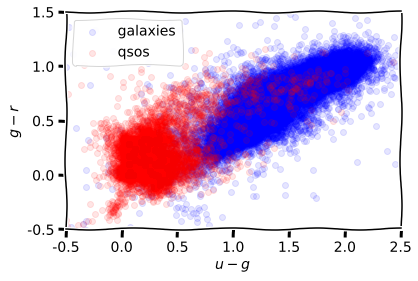

In [32]:
# Let's take a quick look at some of the colors!
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 1.5)

    ax.scatter(ug[galaxies], gr[galaxies], c='b', label='galaxies', alpha=0.1)
    ax.scatter(ug[qsos], gr[qsos], c='r', label='qsos', alpha=0.1)

    ax.legend(loc=2)

    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')

    plt.show()

# Machine Learning
Now that we have the color vectors and labels, let's look at applying a basic machine learning algorithm to do the classification!

In [33]:
train_per = int(0.8*len(color_vec))
#Let's make our training and test sets
X_train = color_vec[:train_per]
Y_train = spec_class[:train_per]
X_test = color_vec[train_per:]
Y_test = spec_class[train_per:]

print(len(X_train), len(X_test))

Y_train_enc = []
for val in Y_train:
    if val == 'GALAXY':
        Y_train_enc.append(0)
    else:
        Y_train_enc.append(1)
Y_test_enc = []
for val in Y_test:
    if val == 'GALAXY':
        Y_test_enc.append(0)
    else:
        Y_test_enc.append(1)

40000 10000


In [38]:
activation = 'relu'  # activation function
initializer = 'normal'  # model initializer
max_epochs = 15  # maximum number of interations
lr = 0.001  # initial learning rate
loss_function = 'sparse_categorical_crossentropy'
metrics_ = ['accuracy', 'mae', 'mse']

model = Sequential([
    Dense(units=100, kernel_initializer=initializer, activation=activation),
    Dropout(0.5),
    Dense(units=100, kernel_initializer=initializer, activation=activation),
    Dense(2, activation='softmax'),
])

optimizer = Adam(lr=lr)
#optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_)

## Now that we have everything defined, let's train and test the network

In [39]:
model.fit(X_train, np.array(Y_train_enc), epochs=max_epochs)
model.summary()

Epoch 1/15
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1383 - accuracy: 0.9522 - mae: 0.5000 - mse: 0.4531
Epoch 2/15
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0717 - accuracy: 0.9819 - mae: 0.5000 - mse: 0.4823
Epoch 3/15
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0664 - accuracy: 0.9820 - mae: 0.5000 - mse: 0.4845
Epoch 4/15
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0606 - accuracy: 0.9828 - mae: 0.5000 - mse: 0.4854
Epoch 5/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0585 - accuracy: 0.9842 - mae: 0.5000 - mse: 0.4862
Epoch 6/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0603 - accuracy: 0.9825 - mae: 0.5000 - mse: 0.4857
Epoch 7/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0572 - accuracy: 0.9837 - mae: 0.5000 - mse: 0.4868
Epoch 8/15
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0560 - accur

In [40]:
test_predictions = model.predict(X_test)
print(test_predictions)
len(test_predictions)

[[0.9924804  0.00751959]
 [0.9937681  0.00623187]
 [0.99383014 0.00616986]
 ...
 [0.9908597  0.00914039]
 [0.9907664  0.00923359]
 [0.99361986 0.00638015]]


10000

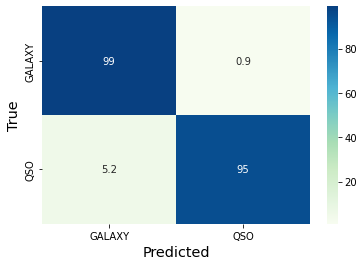

In [41]:
predictions = [np.argmax(pred) for pred in test_predictions]

matrix_conf = confusion_matrix(Y_test_enc,predictions)

# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)*100
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='GnBu', xticklabels=['GALAXY', 'QSO'], yticklabels=['GALAXY', 'QSO'])
#sns_plot.set(xticklabels=np.arange(1,5))
#sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
#sns_fig.savefig('Confusion-Matrix.pdf', type='pdf')